# 导入必要的库

第一个验证码比较简单，只有数字，所以直接从网站抓了5000个图片下来，人工标注，直接训练
标注好的文件放在../captcha/kkk
图片比较小，所以用了(2,2)卷积核


In [4]:

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits 
print(characters)

width, height, n_len, n_class = 50, 22, 4, len(characters)

0123456789


# 定义数据生成器

In [29]:
from keras.utils.np_utils import to_categorical

def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height, fonts=('c:/Windows/Fonts/ARIALN.TTF',), font_sizes=(20,28,34))
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

In [17]:
from keras.utils.np_utils import to_categorical
from PIL import Image as pilImage
import os
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
 
    counter = 0
    while True: 
        list_dirs = os.walk("..\cap\kkk") 
        for root, dirs, files in list_dirs: 
            for f in files: 
                file = os.path.join(root, f) 
                #print(f,file)
                X[counter] = pilImage.open(file)
                for j, ch in enumerate(f[0:4]):
                    y[j][counter, :] = 0
                    y[j][counter, characters.find(ch)] = 1
                counter += 1
                if counter == batch_size:
                    yield X, y
                    #print('counter=%d',counter)
                    counter = 0


# 测试生成器

In [6]:
num=2
genImg=gen(num)

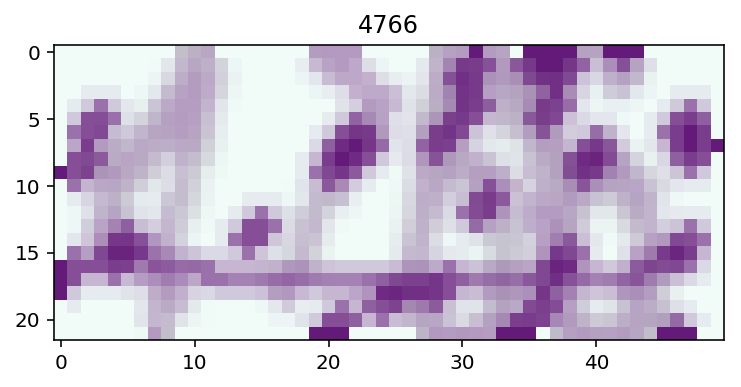

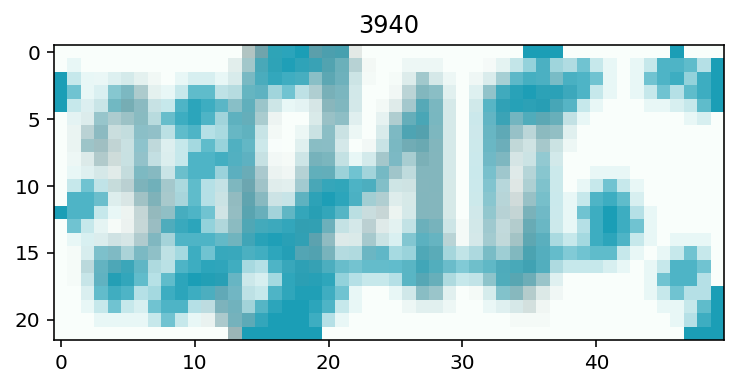

In [30]:
num=2
genImg=gen(num)
def decode(y,i):
    y = np.argmax(np.array(y), axis=2)[:,i]
    return ''.join([characters[x] for x in y])
X, y = next(genImg)
for i in range (num):
    plt.imshow(X[i])
    plt.title(decode(y,i))
    plt.show()
    #print(y)
   # print(X[i])

# 定义网络结构

In [5]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
#print(x)
for i in range(3):
    x = Conv2D(32*2**i, (2, 2), activation='relu', data_format='channels_last')(x)
    x = Conv2D(32*2**i, (2, 2), activation='relu', data_format='channels_last')(x)
    x = MaxPooling2D((2, 2), data_format='channels_last')(x)

x = Flatten()(x)
x = Dropout(0.25)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]
model = Model(inputs=input_tensor, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

# 网络结构可视化

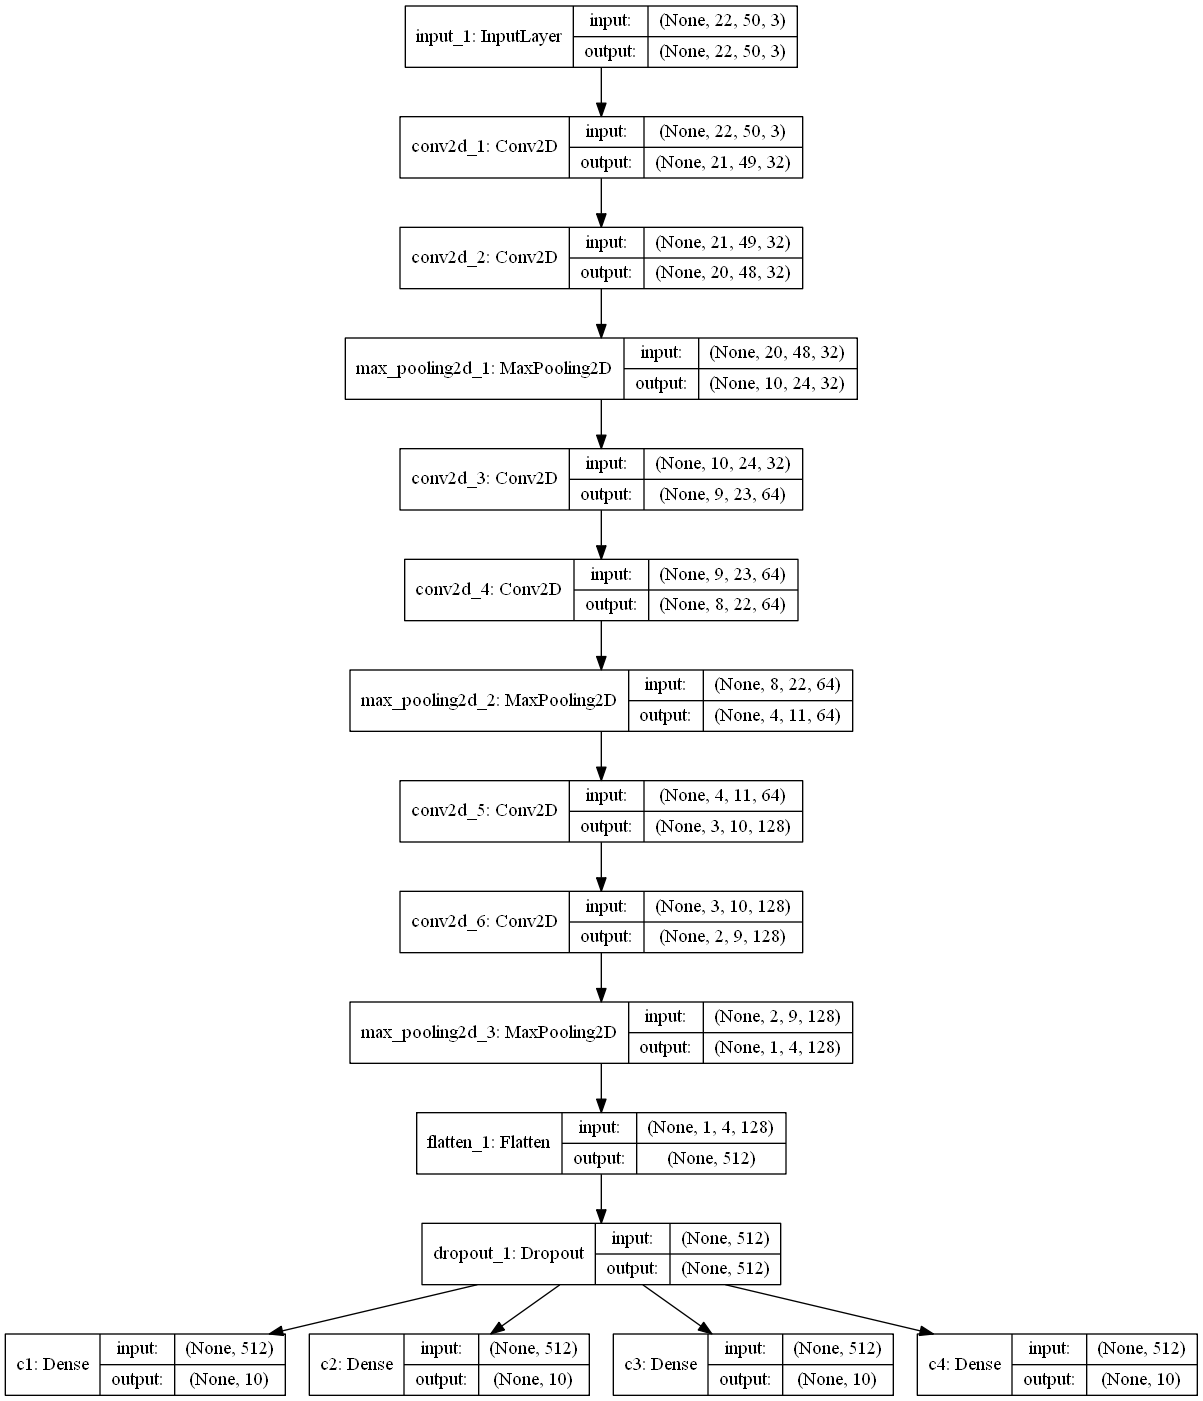

In [8]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

# 训练模型

In [7]:
model.fit_generator(gen(), steps_per_epoch=2000, epochs=5,
                    validation_data=gen(), validation_steps=1280)

Epoch 1/5
2000/2000 [==============================] - 259s 130ms/step - loss: 6.4574 - c1_loss: 0.6742 - c2_loss: 1.9937 - c3_loss: 1.9057 - c4_loss: 1.8839 - c1_acc: 0.8227 - c2_acc: 0.2494 - c3_acc: 0.2903 - c4_acc: 0.3020 - val_loss: 10.9434 - val_c1_loss: 10.6322 - val_c2_loss: 0.1135 - val_c3_loss: 0.1101 - val_c4_loss: 0.0876 - val_c1_acc: 0.1029 - val_c2_acc: 0.9797 - val_c3_acc: 0.9826 - val_c4_acc: 0.9857
Epoch 2/5
2000/2000 [==============================] - 265s 132ms/step - loss: 0.1920 - c1_loss: 0.0784 - c2_loss: 0.0378 - c3_loss: 0.0409 - c4_loss: 0.0348 - c1_acc: 0.9775 - c2_acc: 0.9905 - c3_acc: 0.9899 - c4_acc: 0.9906 - val_loss: 6.1454 - val_c1_loss: 6.0286 - val_c2_loss: 0.0425 - val_c3_loss: 0.0358 - val_c4_loss: 0.0385 - val_c1_acc: 0.3992 - val_c2_acc: 0.9957 - val_c3_acc: 0.9963 - val_c4_acc: 0.9971
Epoch 3/5
2000/2000 [==============================] - 259s 129ms/step - loss: 0.0595 - c1_loss: 0.0291 - c2_loss: 0.0097 - c3_loss: 0.0095 - c4_loss: 0.0112 - c1_a

# 测试模型

In [13]:
genImg1=gen(1)


(-0.5, 49.5, 21.5, -0.5)

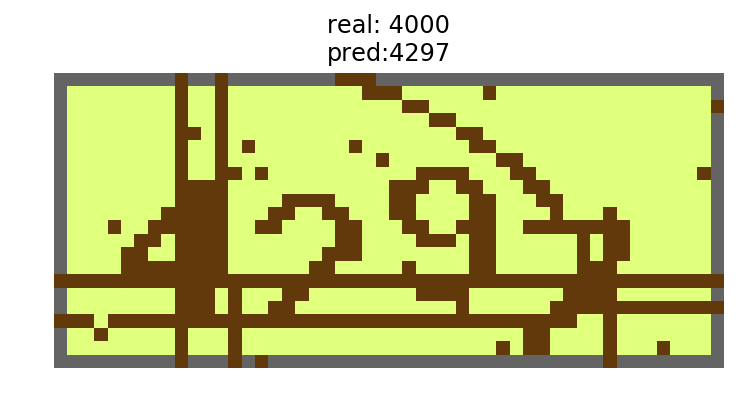

In [36]:
X, y = next(genfile("4297.png"))

y_pred = model.predict(X)

plt.title('real: %s\npred:%s'%(decode(y,0 ), decode(y_pred, 0)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

# 计算模型总体准确率

In [8]:
from tqdm import tqdm
def evaluate(model, batch_num=20):
    batch_acc = 0
    generator = gen()
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        batch_acc += np.mean(list(map(np.array_equal, np.argmax(y, axis=2).T, np.argmax(y_pred, axis=2).T)))
    return batch_acc / batch_num

evaluate(model)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 11.15it/s]


1.0

# 保存模型

In [17]:
model.save('cnn.h5')

In [3]:
from keras.models import load_model
 
model = load_model('cnn.h5')

In [37]:
from keras.utils.np_utils import to_categorical
from PIL import Image as pilImage
import os
def genfile(filename):
    X = np.zeros((1, height, width, 3), dtype=np.uint8)
    y = [np.zeros((1, n_class), dtype=np.uint8) for i in range(n_len)]
    dir_pre ="..\cap\CAPTCHA"
    file = os.path.join(dir_pre, filename) 
    X[0] = pilImage.open(file)
    for j, ch in enumerate(filename[0:4]):
        y[j][0, :] = 0
        y[j][0, characters.find(ch)] = 1
        yield X, y




(-0.5, 49.5, 21.5, -0.5)

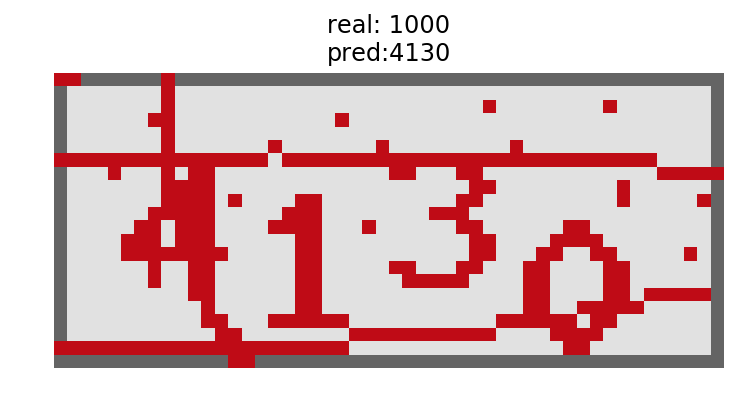

In [38]:

X, y = next(genfile("1900.png"))

y_pred = model.predict(X)

plt.title('real: %s\npred:%s'%(decode(y,0 ), decode(y_pred, 0)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')

(-0.5, 49.5, 21.5, -0.5)

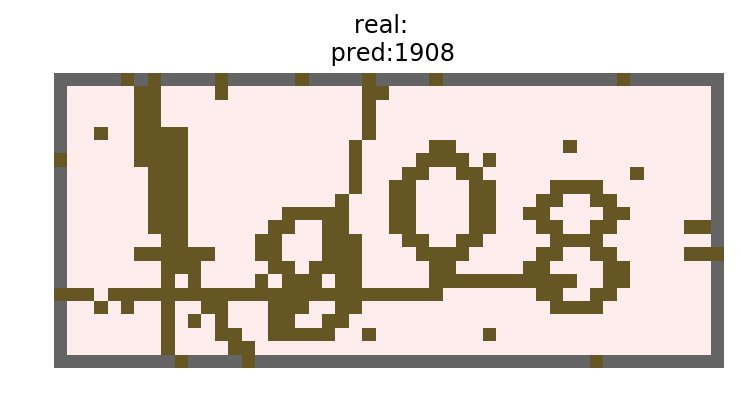

In [35]:
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
from PIL import Image as pilImage
import os
dir_pre ="..\cap\CAPTCHA"
width, height, n_len, n_class = 50, 22, 4, len(characters)
filename = "471.png"
def decode(y,i):
    y = np.argmax(np.array(y), axis=2)[:,i]
    return ''.join([characters[x] for x in y])
#model = load_model('cnn.h5')

X = np.zeros((1, height, width, 3), dtype=np.uint8)
y = [np.zeros((1, n_class), dtype=np.uint8) for i in range(n_len)]

file = os.path.join(dir_pre, filename) 
X[0] = pilImage.open(file)

y_pred = model.predict(X)
plt.title('real:  \n pred:%s'%(decode(y_pred, 0)))
plt.imshow(X[0], cmap='gray')
plt.axis('off')